# Deep Q-Learning and its application for stock trading

## Produced by:
- Anton Chumakov
- Clement Garancini
- Jesse Giroux

In [ ]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# Import libraries
from IPython.display import SVG, display
import numpy as np
import random
import pandas as pd
from abc import abstractmethod
from typing import Tuple, Dict
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import talib

# Introduction

Explain...

# DATA

In [3]:
def fetch_and_save_stock_data(stock_symbol: str, start_date, end_date, file_name):
    """
    Fetch data from yf database and store it in the current repository.
    Once it is done, the data can be accessed using pd.read_csv(filename)
    """
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    stock_data = preprocess_data(stock_data)
    stock_data.to_csv(file_name)
    print(f"Data for {stock_symbol} saved to {file_name}")


def preprocess_data(df: pd.DataFrame):
    """
    Preprocess the data for our experiments
    """
    df.replace(0, np.nan, inplace=True)

    # Forward and backward fill to handle NaNs
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)

    return df


# Example usage
fetch_and_save_stock_data("PEP", "2010-01-01", "2023-01-01", "pepsi_data.csv")
fetch_and_save_stock_data("KO", "2010-01-01", "2023-01-01", "cola_data.csv")

[*********************100%%**********************]  1 of 1 completed
Data for PEP saved to pepsi_data.csv


/var/folders/bb/28t4vmy165xd8xnxpr121xdc0000gn/T/ipykernel_4781/2278559287.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/var/folders/bb/28t4vmy165xd8xnxpr121xdc0000gn/T/ipykernel_4781/2278559287.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


[*********************100%%**********************]  1 of 1 completed
Data for KO saved to cola_data.csv


/var/folders/bb/28t4vmy165xd8xnxpr121xdc0000gn/T/ipykernel_4781/2278559287.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/var/folders/bb/28t4vmy165xd8xnxpr121xdc0000gn/T/ipykernel_4781/2278559287.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


# Part 1. **Simplified discrete** stock trading problem
---
---

Explain...

## 1.1 Markov Decision Process (MDP)

---

MDP introduction...

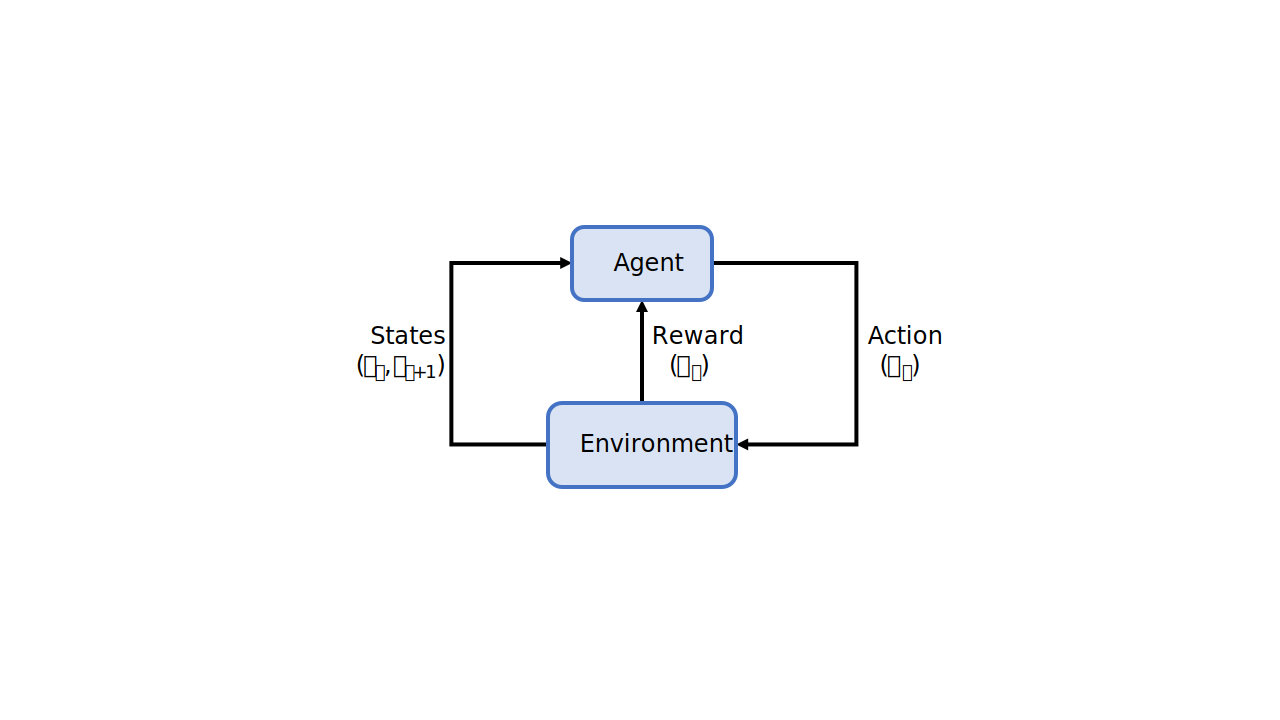

In [4]:
display(SVG(url="https://drive.google.com/uc?id=1vEy83A9RqWPIKc1eTgXue0zQYFxFHwPV"))

### States (S)

Explain...

### Actions (A)

Explain...

### Rewards (R)

Explain...

## 1.2 Q-Learning
---

Q-Learning introduction...

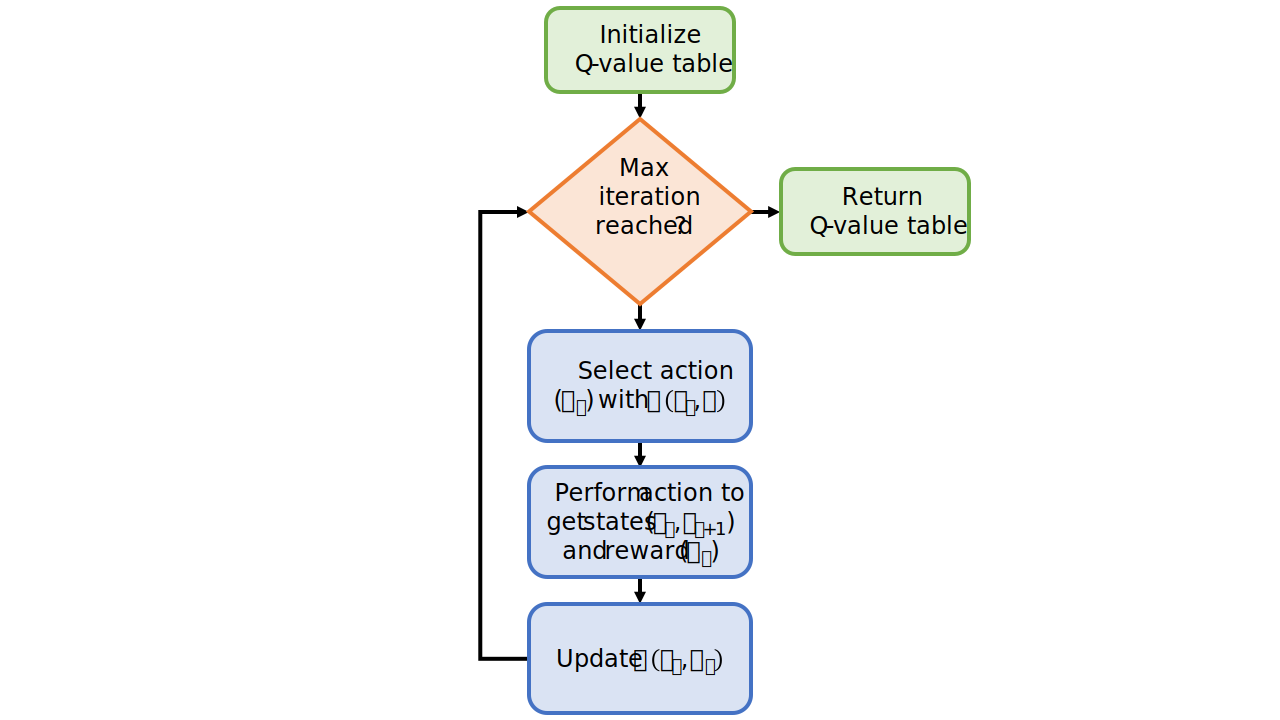

In [5]:
display(SVG(url="https://drive.google.com/uc?id=1GnWrILTMWa5YU_tIjd3GuF5GiwZA4O1L"))

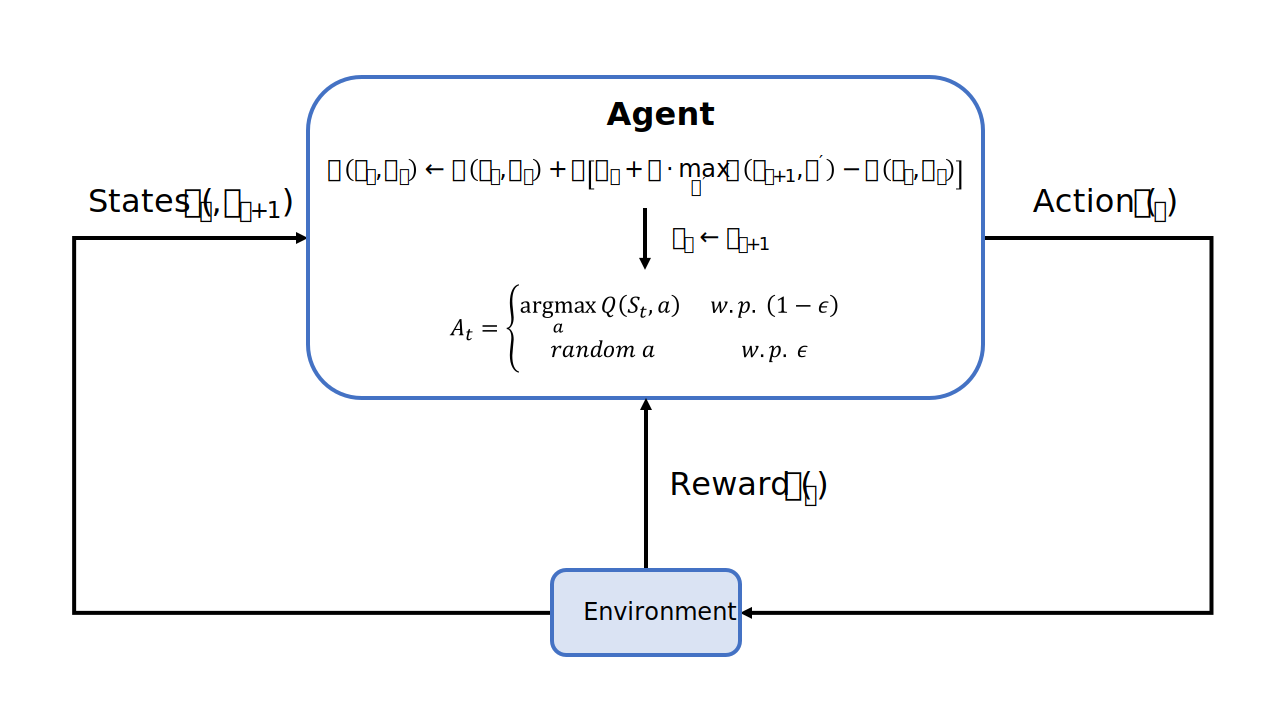

In [6]:
display(SVG(url="https://drive.google.com/uc?id=15u_iFwGZ8F2-r10OjjcoUDZ1YX6R8qkh"))

### Initialize Q-value table

Explain...

### Select an action ($A_{t}$) with $Q(S_{t}, a)$

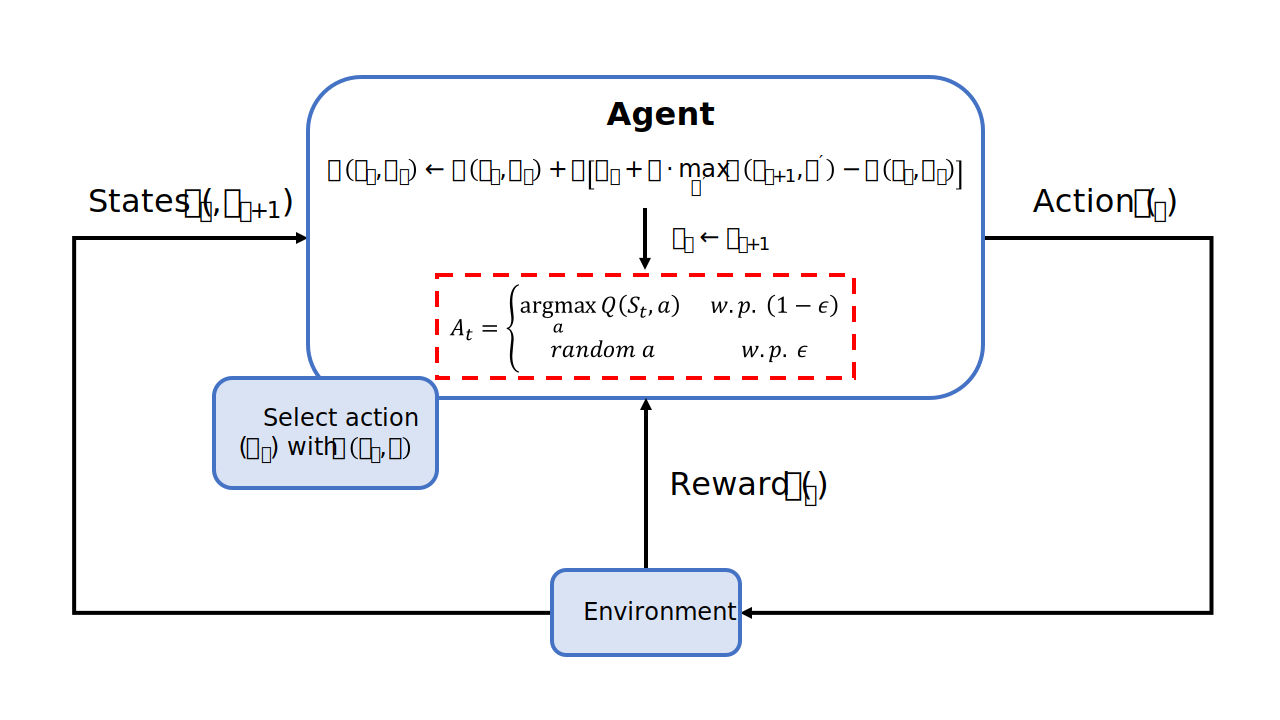

In [7]:
display(SVG(url="https://drive.google.com/uc?id=1cZlF1HessLf5_goCwAxM9V_KSaB2pBFY"))

Explain...

### Perform an action to get states $(S_{t}, S_{t+1})$ and reward $(R_{t})$

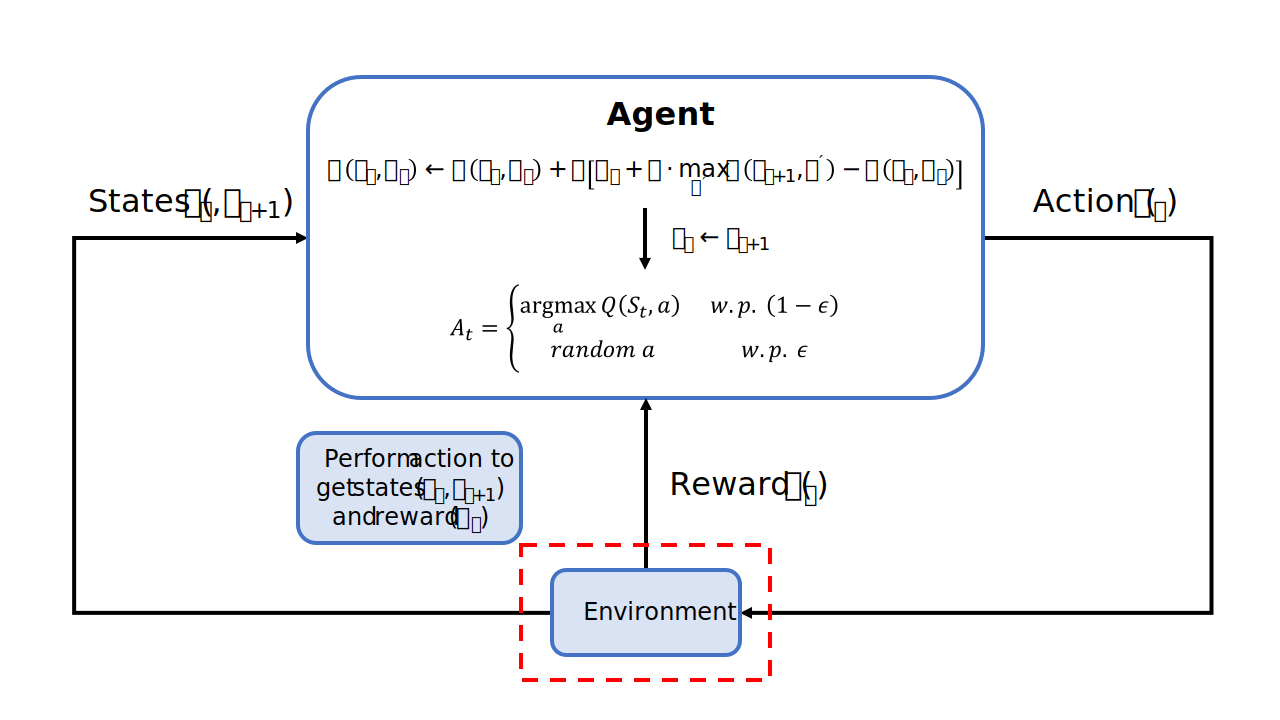

In [8]:
display(SVG(url="https://drive.google.com/uc?id=1a56GNy52ddeAmUUp8HNVl1RkEV1pXXlW"))

Explain...

### Update $Q(S_{t}, A_{t})$

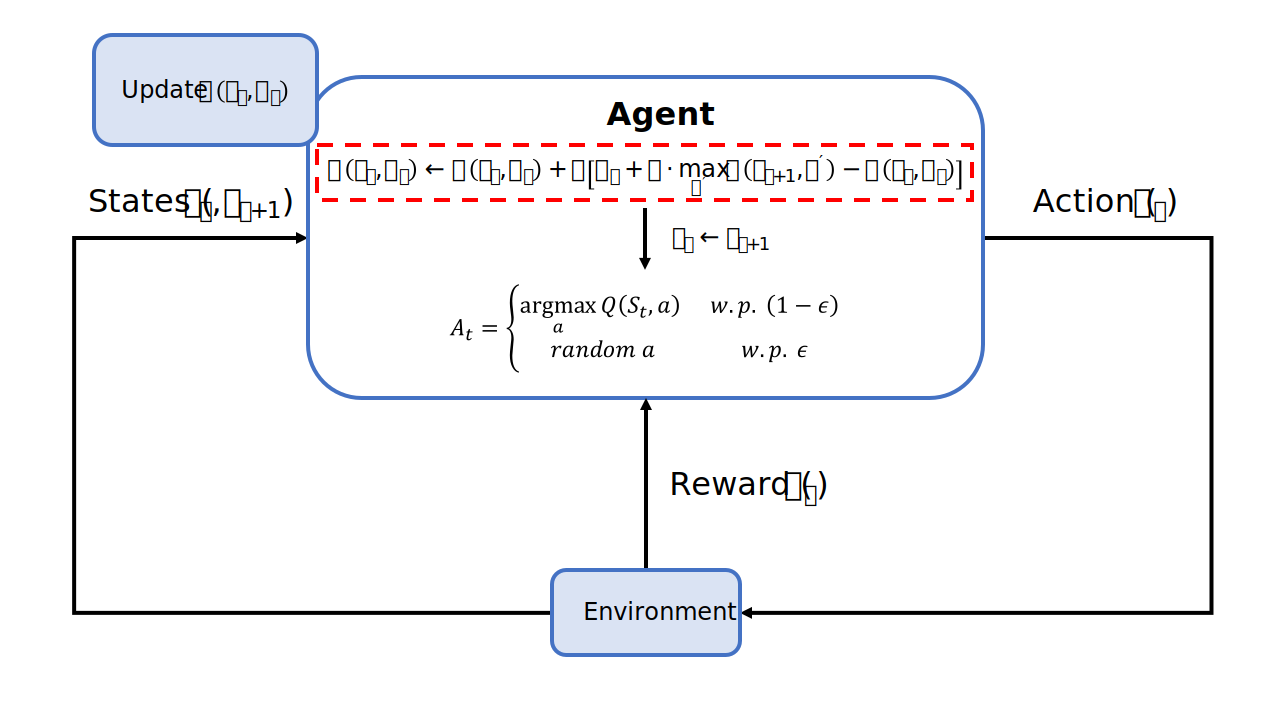

In [9]:
display(SVG(url="https://drive.google.com/uc?id=1n1rNgwsfQHIXMeivchSQGMye6QC4OlaN"))

Explain...

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \cdot [R +  \gamma \cdot \underset{a'}{\mathrm{max}} Q(s', a') - Q(s, a)]
$$

Where:
- $Q(s, a)$ is ...
- $\alpha$ is ...
- $R$ is ...
- $\gamma$ is ...
- $s'$ is ...
- $a'$ is ...

## 1.3 Q-Learning for stock trading with 1 discrete technical indicator
---

### **Simplified discrete** stock trading problem with Q-Learning

Explain...

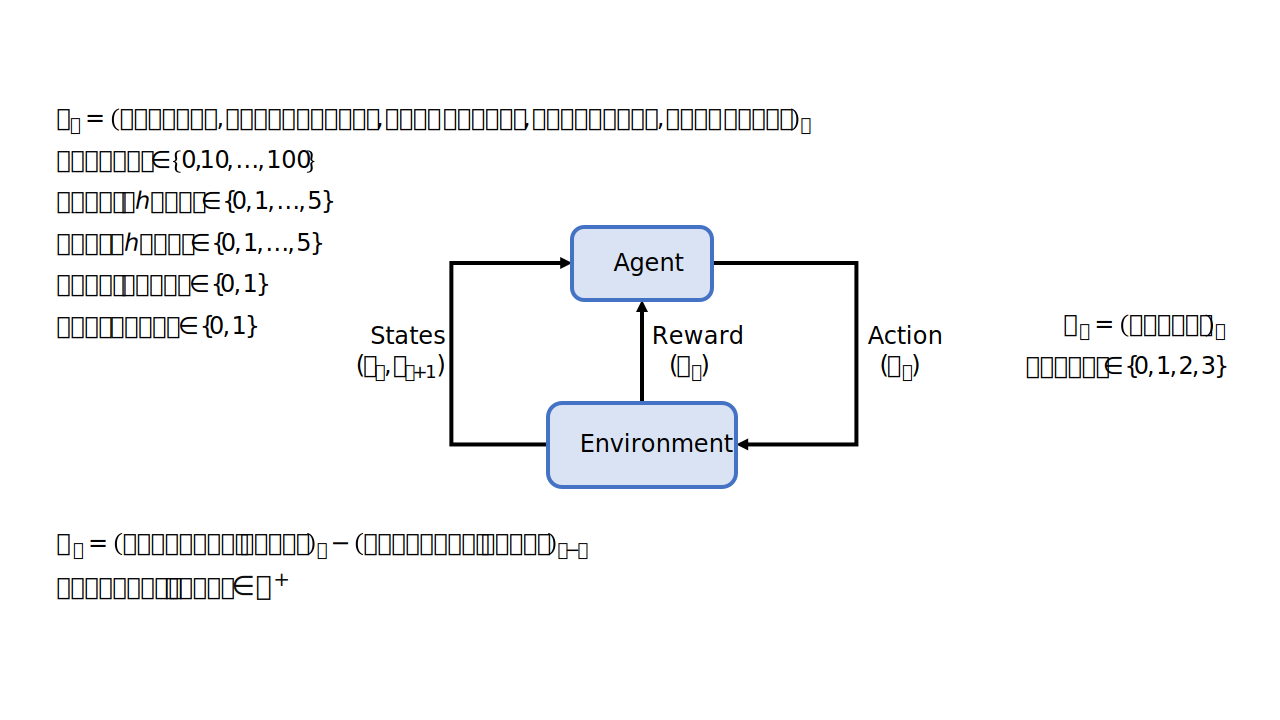

In [10]:
display(SVG(url="https://drive.google.com/uc?id=1WCiOcRt63nJ8cjUiHGt-IdcRLL29to8c"))

## 1.4 Experiment 1: **Simplified discrete** stock trading problem
---

In [11]:
class TradingEnvironment:
    """
    Our basic Environment Class, it implements all the common methods of MDP Environment
    """

    def __init__(
        self, pepsi_file: str, cola_file: str, observation_dim: int, action_dim: int
    ):
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.pepsi_data = pd.read_csv(pepsi_file)
        self.pepsi_data.Name = "Pepsi"
        self.cola_data = pd.read_csv(cola_file)
        self.cola_data.Name = "Cola"

        self.action_space = range(action_dim)
        self.state = np.zeros(observation_dim)

        self.current_step = 0
        self.portfolio_value = self._compute_portfolio_value()

    def step(self, action: int) -> Tuple[np.ndarray | int, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            state: np.ndarray, The next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        self._check_action_validity(action)
        self.state = self._trade(action)
        self.current_step += 1
        done = self.current_step >= len(self.pepsi_data) - 1
        reward = self._compute_reward()
        return self.state, reward, done

    @abstractmethod
    def reset(self) -> np.ndarray | int:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _trade(self, action: int) -> np.ndarray:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _get_indicator(self, stock_data: pd.DataFrame) -> int | float:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _check_action_validity(self, action: int) -> None:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _compute_portfolio_value(self) -> float:
        # Not Implemented
        raise NotImplementedError

    def _get_stock_price(self, step: int, stock_data: pd.DataFrame) -> float:
        """
        Fetch the price for the given step and stock
        """
        return stock_data.iloc[step]["Adj Close"]

    def _get_stock_trend(self, step: int, stock_data: pd.DataFrame) -> float:
        """
        Fetch the trend for the given stock between the given step and the previous one
        """
        return (
            stock_data.iloc[step]["Adj Close"] - stock_data.iloc[step - 1]["Adj Close"]
        )

    def _compute_reward(self) -> float:
        """
        Computes and updates the portfolio value and returns the reward associated
        The reward is the difference between the current portfolio value and the previous one
        """
        current_portfolio_value = self._compute_portfolio_value()
        reward = current_portfolio_value - self.portfolio_value
        self.portfolio_value = current_portfolio_value
        return reward

In [12]:
class SimplifiedDiscreteTradingEnvironment(TradingEnvironment):
    """
    The environment corresponding to the 1st experiment.

    State space = {0..10} x {0..5} x {0..5} x {0,1} x {0,1}
        representing respectively
            the remaining balance,
            the number of pepsi shares held,
            the number of cola shares held,
            the trend of pepsi stock,
            the trend of cola stock

    Action space = {0..3} for
        0: Sell all
        1: Hold
        2: Buy Pepsi
        3: Buy Cola

    The state is represented with an index in {0..1584} for Q-value tables
    """

    def __init__(self, pepsi_file: str, cola_file: str):
        self.observation_dim = (
            5  # [Balance, Shares Pepsi, Shares Cola, Trend Pepsi, Trend Cola]
        )
        self.action_dim = 4  # 0 = Sell all, 1 = Hold, 2 = Buy Pepsi, 3 = Buy Cola

        self.balance_unit = 10
        self.max_balance_units = 10
        self.max_shares_per_stock = 5

        self.max_state_index = (
            11 * 6 * 6 * 2 * 2
        )  # 11 balances, 6 shares each for Pepsi and Cola, 2 trends each

        super().__init__(pepsi_file, cola_file, self.observation_dim, self.action_dim)

        self.state = np.array(
            [10, 0, 0, 0, 0]
        )  # Initial state: [Balance, Pepsi shares, Cola shares, Trend of Pepsi, Trend of Cola]

    def __str__(self) -> str:
        info = """The environment is a Simplified Discrete Trading Problem (Experiment 1).\n 
        It is using the stocks: {}, {}
        The episode is at the timestep {}
        The current stock prices are {}$ and {}$
        Amount of shares held by the agent: {}
        Left balance: {}""".format(
            self.pepsi_data.Name,
            self.cola_data.Name,
            self.current_step,
            np.round(self._get_stock_price(self.current_step, self.pepsi_data), 2),
            np.round(self._get_stock_price(self.current_step, self.cola_data), 2),
            self.state[1:3],
            self.state[0],
        )

        return info

    def step(self, action: int) -> Tuple[int, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            next_state_index: int, The index of the next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        self._check_action_validity(action)
        self.state = self._trade(action)
        self.current_step += 1
        done = self.current_step >= len(self.pepsi_data) - 1
        reward = self._compute_reward()
        state_index = self.convert_state_to_index(self.state)
        return state_index, reward, done

    def reset(self) -> int:
        """
        Reset the environment to its initial State

        Returns:
            state_index: int, The initial state as index
        """
        self.state = np.array([10, 0, 0, 0, 0])
        self.current_step = 0
        self.portfolio_value = self._compute_portfolio_value()
        state_index = self.convert_state_to_index(self.state)
        return state_index

    def _trade(self, action: int) -> np.ndarray:
        """
        Trade the desired amount

        Args:
            action: int, The trade order, can be
                - 0: Sell all
                - 1: Hold
                - 2: Buy Pepsi
                - 3: Buy Cola

        Returns:
            state: np.ndarray, The state after the trade
        """
        balance_units, shares_pepsi, shares_cola = (
            self.state[0],
            self.state[1],
            self.state[2],
        )
        balance = balance_units * self.balance_unit
        pepsi_price = self._get_stock_price(self.current_step, self.pepsi_data)
        cola_price = self._get_stock_price(self.current_step, self.cola_data)

        if action == 0:  # Sell all
            balance += shares_pepsi * pepsi_price + shares_cola * cola_price
            shares_pepsi, shares_cola = 0, 0
        elif action == 2:  # Buy Pepsi
            quantity = min(
                balance // pepsi_price, self.max_shares_per_stock - shares_pepsi
            )
            shares_pepsi += quantity
            balance -= quantity * pepsi_price
        elif action == 3:  # Buy Cola
            quantity = min(
                balance // cola_price, self.max_shares_per_stock - shares_cola
            )
            shares_cola += quantity
            balance -= quantity * cola_price

        # Update state with rounded balance
        new_balance = min(int(balance / self.balance_unit), self.max_balance_units)

        trend_pepsi = self._get_indicator(self.current_step, self.pepsi_data)
        trend_cola = self._get_indicator(self.current_step, self.cola_data)

        return np.array(
            [new_balance, shares_pepsi, shares_cola, trend_pepsi, trend_cola]
        )

    def _get_indicator(self, step: int, stock_data: pd.DataFrame) -> int:
        """
        Compute the indicator used as observation. The

        Args:
            step: int, the current step of the episode
            stock_data: pd.DataFrame, the stock data from which one wants to get the indicator

        Returns
            indicator: int, The indicator giving the trend information (1 for rising, 0 for falling)
        """
        trend = self._get_stock_trend(step, stock_data)
        indicator = int(trend > 0)
        return indicator

    def _check_action_validity(self, action: int) -> None:
        """
        Ensures that parsed action is valid, raise an error if it is not
        """
        if action not in range(self.action_dim):
            raise ValueError("Action must be in [0,{}]".format(self.action_dim - 1))

    def _compute_portfolio_value(self) -> float:
        """
        Compute the current porfolio value
        """
        balance = self.state[0] * self.balance_unit
        pepsi_holdings_value = self.state[1] * self._get_stock_price(
            self.current_step, self.pepsi_data
        )
        cola_holdings_value = self.state[2] * self._get_stock_price(
            self.current_step, self.cola_data
        )
        return balance + pepsi_holdings_value + cola_holdings_value

    def convert_state_to_index(self, state: np.ndarray) -> int:
        balance_index, pepsi_shares, cola_shares, trend_pepsi, trend_cola = state
        index = balance_index
        index += pepsi_shares * 11
        index += cola_shares * 11 * 6
        index += trend_pepsi * 11 * 6 * 6
        index += trend_cola * 11 * 6 * 6 * 2
        return int(index)

    def convert_index_to_state(self, index: int) -> np.ndarray:
        trend_cola = index // (11 * 6 * 6 * 2)
        index %= 11 * 6 * 6 * 2
        trend_pepsi = index // (11 * 6 * 6)
        index %= 11 * 6 * 6
        cola_shares = index // (11 * 6)
        index %= 11 * 6
        pepsi_shares = index // 11
        balance_index = index % 11
        return np.array(
            [balance_index, pepsi_shares, cola_shares, trend_pepsi, trend_cola]
        )

In [13]:
class QLearningAgent:
    """
    The class implementing our agent for Experiment 1
    """

    def __init__(
        self,
        state_space: int,
        action_space: int,
        learning_rate=0.01,
        discount_factor=0.99,
        exploration_rate=1.0,
    ):
        # Env
        self.state_space = state_space
        self.max_state_index = 11 * 6 * 6 * 2 * 2
        self.action_space = action_space

        # Learning
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.q_table = np.zeros((self.max_state_index, action_space))

        # Monitoring
        self.q_table_to_store = np.zeros((11, 6, 6, 2, 2, action_space))
        self.q_table_history = np.zeros((1, 11, 6, 6, 2, 2, action_space))

    def __str__(self) -> str:
        info = """The agent is using Q-Learning algorithm\n
        It is working on Simplified Discrete Trading Environment (Experiment 1)\n
        The current Q Table values can be fetch by calling get_current_q_values() method\n
        The history of Q Table values can be fetch by calling get_history_q_values() method"""
        return info

    def choose_action(self, state_index: int) -> int:
        """
        Choose action according to current Q Table

        Args:
            state_index: int, The index corresponding to the state in which the environment is in

        Returns:
            action: int, The action picked according to the current Q-values
        """
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        return np.argmax(self.q_table[state_index])

    def train(
        self, state_index: int, action: int, reward: float, next_state_index: int
    ) -> None:
        """
        Update Q values following Q Learning classical update

        Args:
            state_index: int, The index corresponding to the state in which the environment was before taking the action
            action: int, The action picked by the agent
            reward: float, The reward that was returned by the environment after the agent took the action
            next_state_index: int, The index corresponding to the state in which the environment is after taking the action
        """
        assert 0 <= state_index < self.max_state_index, "Invalid state_index"
        assert 0 <= next_state_index < self.max_state_index, "Invalid next_state_index"

        q_value = self.q_table[state_index, action]

        # Target = Rt + Gamma x max(Q[S(t+1), a])
        target = reward + self.discount_factor * np.max(self.q_table[next_state_index])

        # Q[S(t), action] =  Q[S(t), action] + alpha x (Rt + Gamma x max(Q[S(t+1), a]) - Q[S(t), action])
        self.q_table[state_index, action] += self.learning_rate * (target - q_value)

        # Update Q table for monitoring
        state = self.convert_index_to_state(state_index)
        self.q_table_to_store[
            state[0], state[1], state[2], state[3], state[4], action
        ] = self.q_table[state_index, action]

        self.exploration_rate = max(
            self.exploration_rate * self.exploration_decay, self.exploration_min
        )

    def store_q_values(self) -> None:
        """
        Stores the current Q-values table in the q_table_history array
        """
        self.q_table_history = np.concatenate(
            (self.q_table_history, [self.q_table_to_store])
        )

    def get_current_q_values(self) -> np.ndarray:
        """
        Fetch the current Q Table as a numpy array of shape:
            (number of possible states, number of possible actions)
        """
        return self.q_table

    def get_history_q_values(self) -> np.ndarray:
        """
        Fetch the history of Q Tables as a numpy array of shape:
            (number of episodes seen, number of possible states, number of possible actions)
        """
        return self.q_table_history

    def convert_index_to_state(self, index: int) -> np.ndarray:
        trend_cola = index // (11 * 6 * 6 * 2)
        index %= 11 * 6 * 6 * 2
        trend_pepsi = index // (11 * 6 * 6)
        index %= 11 * 6 * 6
        cola_shares = index // (11 * 6)
        index %= 11 * 6
        pepsi_shares = index // 11
        balance_index = index % 11
        return np.array(
            [balance_index, pepsi_shares, cola_shares, trend_pepsi, trend_cola]
        )

In [14]:
def train_QLearning_agent(
    env: SimplifiedDiscreteTradingEnvironment, agent: QLearningAgent, num_episodes: int
):
    """
    Performs the training of the Agent for experiment 1

    Args:
        env: SimplifiedDiscreteTradingEnvironment, The Environment which the agent will interact with
        agent: QLearningAgent, The agent that will be trained
        num_episodes: int, The number of episode which the agent will be trained on

    Returns:
        rewards_per_episode: list, The history of rewards over the episodes
        q_values_array: np.ndarray, The history of Q-values tables over the episodes
    """

    rewards_per_episode = []

    for episode in range(num_episodes):
        state_index = env.reset()  # Get the initial state index
        total_rewards = 0

        done = False
        while not done:
            action = agent.choose_action(state_index)
            next_state_index, reward, done = env.step(
                action
            )  # next_state_index is directly obtained here
            agent.train(state_index, action, reward, next_state_index)

            state_index = next_state_index
            total_rewards += reward

        agent.store_q_values()

        rewards_per_episode.append(total_rewards)
        print(f"Episode: {episode}, Total Reward: {total_rewards}")

    q_values_array = agent.get_history_q_values()

    plt.plot(rewards_per_episode)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

    return rewards_per_episode, q_values_array

In [15]:
EnvExp1 = SimplifiedDiscreteTradingEnvironment("pepsi_data.csv", "cola_data.csv")
AgentExp1 = QLearningAgent(state_space=5, action_space=4)
rewards = train_QLearning_agent(env=EnvExp1, agent=AgentExp1, num_episodes=1000)

Episode: 0, Total Reward: -90.0
Episode: 1, Total Reward: -80.0
Episode: 2, Total Reward: -70.0
Episode: 3, Total Reward: -70.0
Episode: 4, Total Reward: -70.0
Episode: 5, Total Reward: -40.0
Episode: 6, Total Reward: -50.0
Episode: 7, Total Reward: -50.0
Episode: 8, Total Reward: -80.0
Episode: 9, Total Reward: -28.335468292236328
Episode: 10, Total Reward: -30.0
Episode: 11, Total Reward: -30.0
Episode: 12, Total Reward: -60.0
Episode: 13, Total Reward: -60.0
Episode: 14, Total Reward: -38.33546829223633
Episode: 15, Total Reward: -28.335468292236328
Episode: 16, Total Reward: 0.0
Episode: 17, Total Reward: -40.0
Episode: 18, Total Reward: -38.33546829223633
Episode: 19, Total Reward: -10.0
Episode: 20, Total Reward: -20.0
Episode: 21, Total Reward: -50.0
Episode: 22, Total Reward: 85.61846923828125
Episode: 23, Total Reward: -18.335468292236328
Episode: 24, Total Reward: -20.0
Episode: 25, Total Reward: -30.0
Episode: 26, Total Reward: -60.0
Episode: 27, Total Reward: 0.0
Episode: 2

KeyboardInterrupt: 

In [ ]:
_, q_values_array = rewards
q_values_array.shape

(1001, 11, 6, 6, 2, 2, 4)

## 1.5 Experiment 1 results
---

### Performance

Plot and analyse results...

### Learned Q-values

Display leanred Q-value table and gain insight...

# Part 2. **Simplified continuous** stock trading problem
---
---

Explain...

## 2.1 Function approximation
---

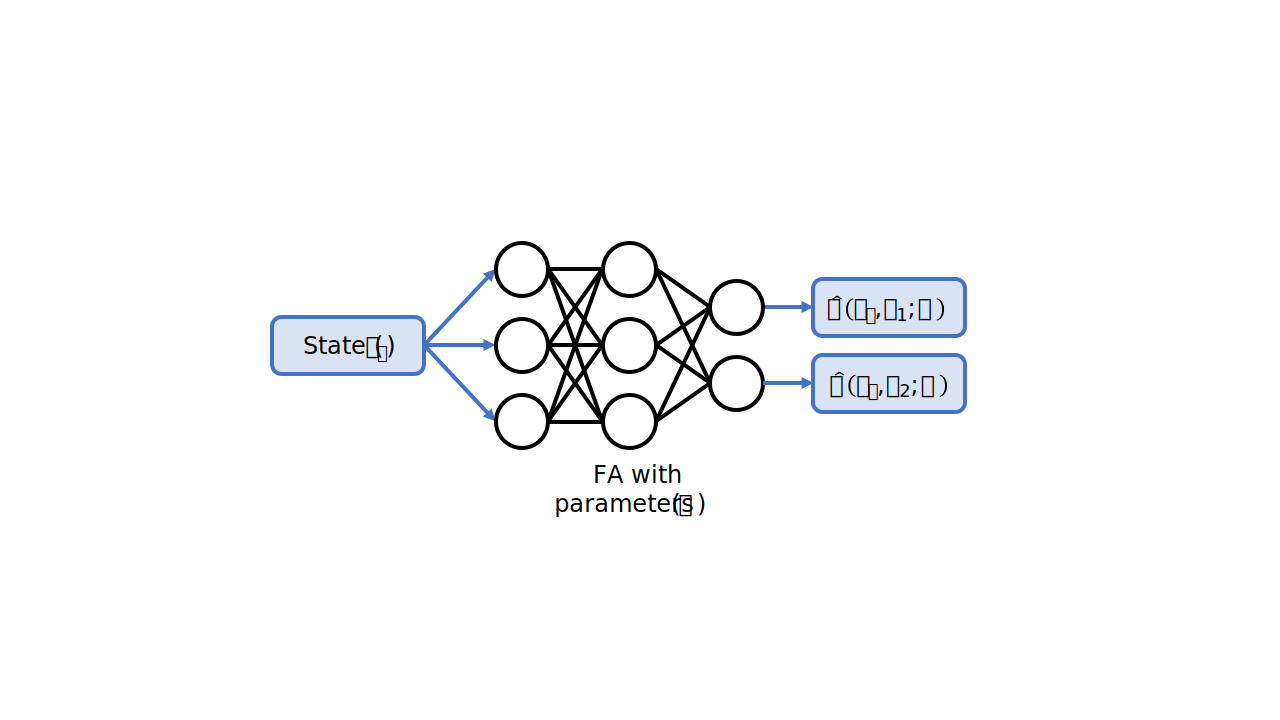

In [ ]:
display(SVG(url="https://drive.google.com/uc?id=1oxtTZ6LkqGDSfdf0_wN2DSSjle3W-7VA"))

Explain...

## 2.2 Deep Q-Learning
---

Deep Q-Learning introduction...

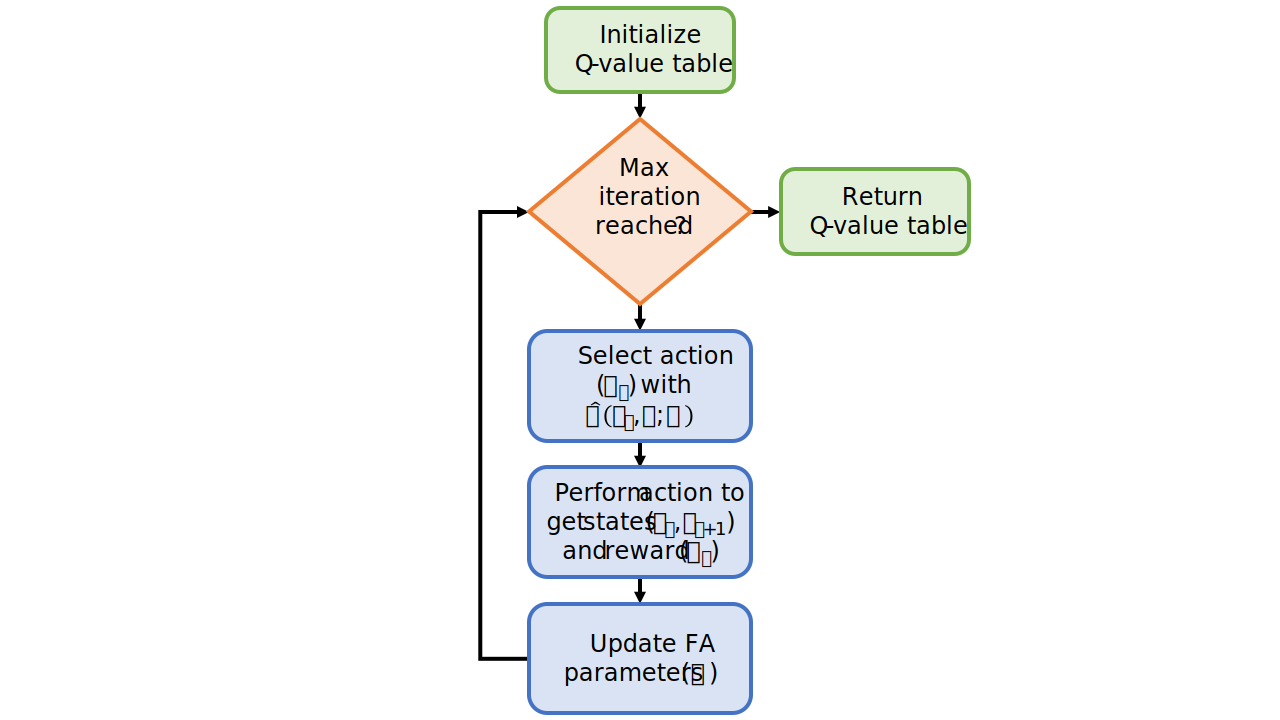

In [ ]:
display(SVG(url="https://drive.google.com/uc?id=1XtgSnYa7Whne9FrQH_IJcmiFfwVW02Yp"))

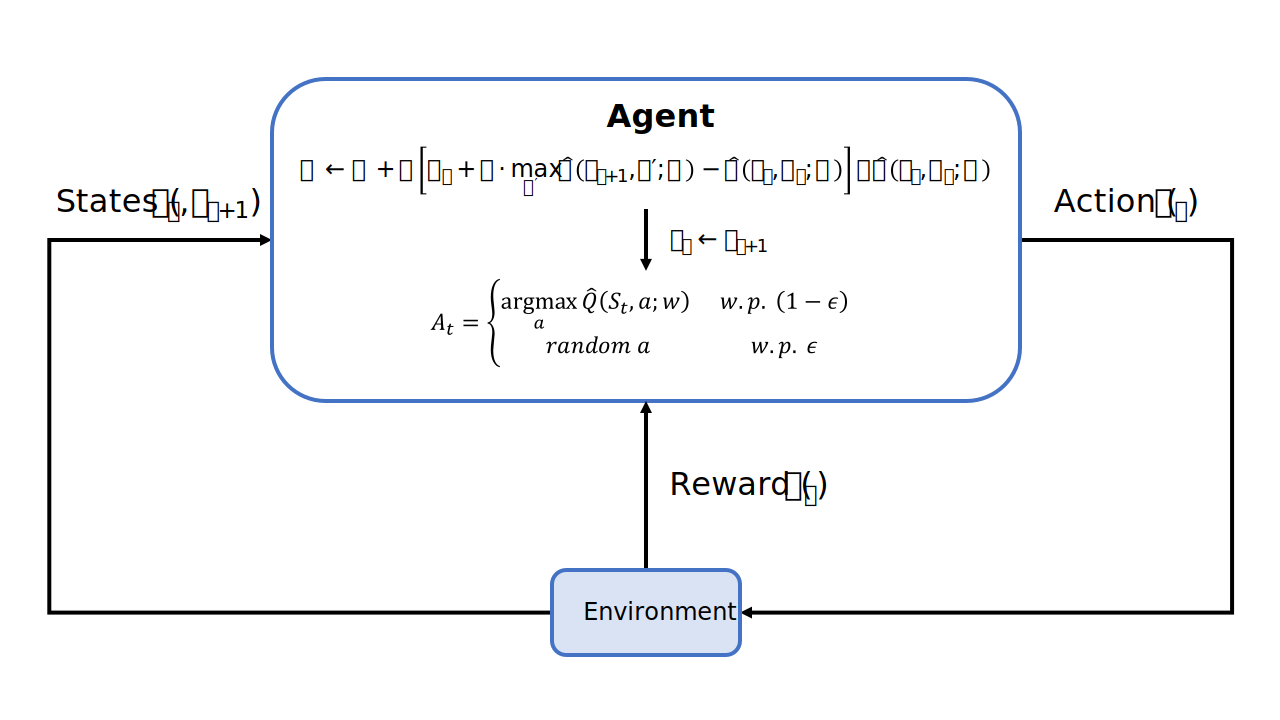

In [ ]:
display(SVG(url="https://drive.google.com/uc?id=1-F-omld3WPjQPmKLo-MSeWRUwYgb1qc0"))

### Select an action ($A_{t}$) with $\hat{Q}(S_{t}, a; w)$

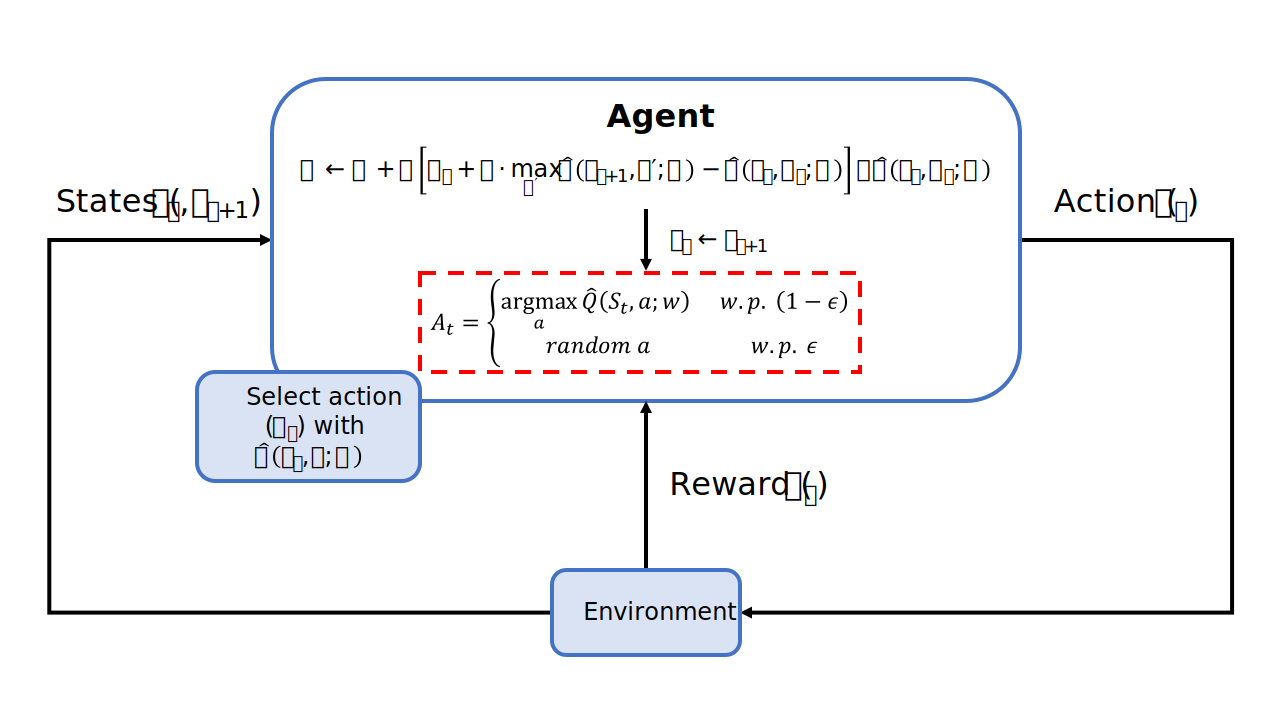

In [ ]:
display(SVG(url="https://drive.google.com/uc?id=1h_o7S6YSS6_HhRdtABXRJB3IIT0UMpPA"))

### Update FA parameters ($w$)

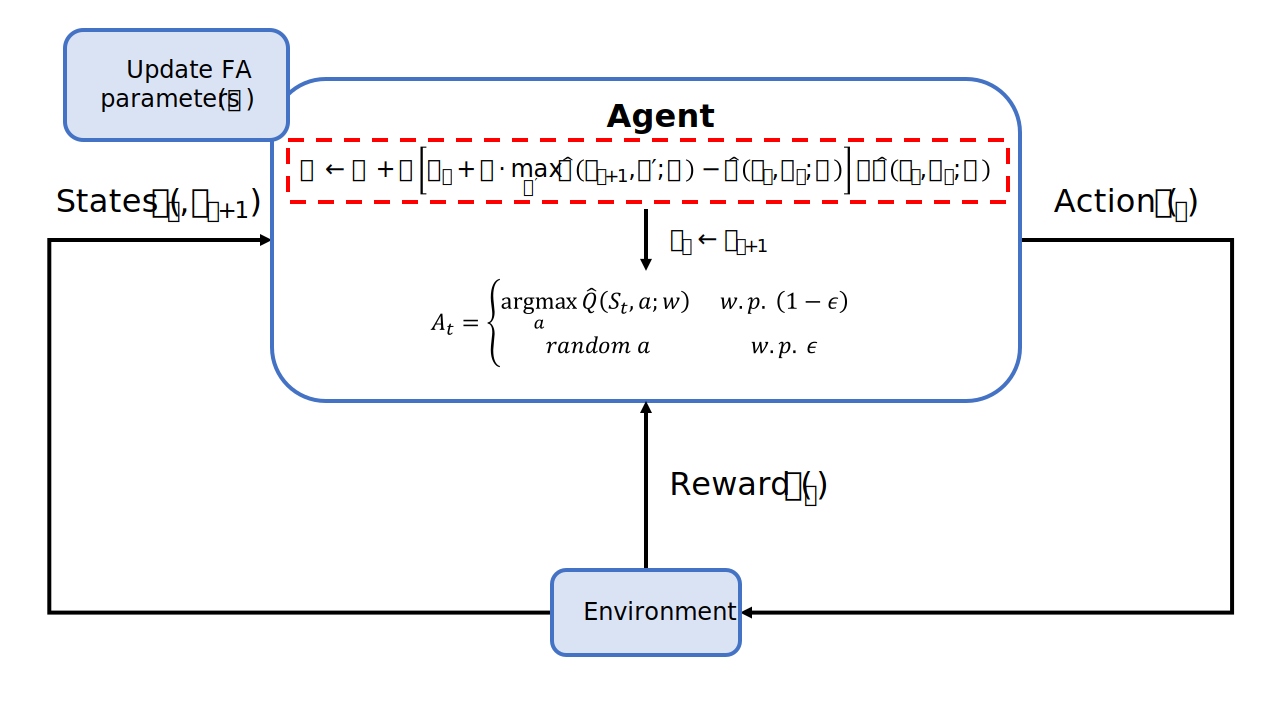

In [ ]:
display(SVG(url="https://drive.google.com/uc?id=14eqczRrPlBxd7NGBggcNZnHrdaON6S79"))

## 2.3 Deep Q-Learning for stock trading with 1 continuous technical indicator
---

### **Simplified continuous** stock trading problem with deep Q-Learning

Explain...

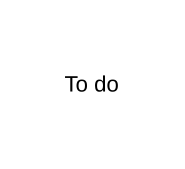

In [ ]:
display(SVG(url="https://drive.google.com/uc?id=1lVKdS06Sc9lCtW_P3Ek48gTYdJfvfRz-"))

## 2.4 Experiment 2: **Simplified continuous** stock trading problem
---

In [ ]:
class SimplifiedContinuousTradingEnvironmentDQN(TradingEnvironment):
    def __init__(self, pepsi_file, cola_file):
        observation_dim = (
            5  # balance, shares of Pepsi, shares of Cola, trend of Pepsi, trend of Cola
        )
        action_dim = 4  # Sell all, Hold, Buy Pepsi, Buy Cola
        super().__init__(
            pepsi_file,
            cola_file,
            observation_dim=observation_dim,
            action_dim=action_dim,
        )

        self.state = np.array([10000.0, 0, 0, 0, 0])  # Initial state

    def __str__(self) -> str:
        info = """The environment is a Simplified Continuous Trading Problem (Experiment 2).\n 
        It is using the stocks: {}, {}
        The episode is at the timestep {}
        The current stock prices are {}$ and {}$
        Amount of shares held by the agent: {}
        Left balance: {}""".format(
            self.pepsi_data.Name,
            self.cola_data.Name,
            self.current_step,
            np.round(self._get_stock_price(self.current_step, self.pepsi_data), 2),
            np.round(self._get_stock_price(self.current_step, self.cola_data), 2),
            self.state[1:3],
            self.state[0],
        )

        return info

    def step(self, action: int) -> Tuple[np.ndarray, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            state: np.ndarray, The next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        return super().step(action)

    def reset(self) -> np.ndarray:
        """
        Reset the environment to its initial State

        Returns:
            state: np.ndarray, The initial state
        """
        self.state = np.array([10000.0, 0, 0, 0, 0])  # Reset to initial state
        self.current_step = 0
        return self.state

    def _trade(self, action: int) -> np.ndarray:
        """
        Trade the desired amount

        Args:
            action: int, The trade order, can be
                - 0: Sell all
                - 1: Hold
                - 2: Buy Pepsi
                - 3: Buy Cola
        """
        balance, shares_pepsi, shares_cola = self.state[0], self.state[1], self.state[2]
        pepsi_price = self._get_stock_price(self.current_step, self.pepsi_data)
        cola_price = self._get_stock_price(self.current_step, self.cola_data)

        if action == 0:  # Sell all
            balance += shares_pepsi * pepsi_price + shares_cola * cola_price
            shares_pepsi, shares_cola = 0, 0
        elif action == 2:  # Buy Pepsi
            quantity = balance / pepsi_price
            if quantity > 0:
                shares_pepsi += quantity
                balance -= quantity * pepsi_price
        elif action == 3:  # Buy Cola
            quantity = balance / cola_price
            if quantity > 0:
                shares_cola += quantity
                balance -= quantity * cola_price

        trend_pepsi = self._get_indicator(self.current_step, self.pepsi_data)
        trend_cola = self._get_indicator(self.current_step, self.cola_data)

        return np.array([balance, shares_pepsi, shares_cola, trend_pepsi, trend_cola])

    def _get_indicator(self, step: int, stock_data: pd.DataFrame) -> float:
        """
        Compute the indicator used as observation. The

        Args:
            step: int, the current step of the episode
            stock_data: pd.DataFrame, the stock data from which one wants to get the indicator

        Returns
            indicator: float, The indicator giving the trend information (price at current step - price at previous step)
        """
        return self._get_stock_trend(step, stock_data)

    def _check_action_validity(self, action: int) -> None:
        """
        Ensures that parsed action is valid, raise an error if it is not
        """
        if action not in range(self.action_dim):
            raise ValueError("Action must be in [0,{}]".format(self.action_dim - 1))

    def _compute_portfolio_value(self) -> float:
        """
        Compute the current porfolio value
        """
        pepsi_price = self._get_stock_price(self.current_step, self.pepsi_data)
        cola_price = self._get_stock_price(self.current_step, self.cola_data)
        return self.state[0] + self.state[1] * pepsi_price + self.state[2] * cola_price

In [ ]:
class DQNAgent:
    def __init__(self, state_size: int, action_size: int):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []  # Memory for experience replay

        # Hyperparameters
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001

        self.model = self._build_model()

        # Monitoring
        self.model_states = []

    def _build_model(self) -> nn.Sequential:
        """
        Define a simple Neural Network model

        Returns:
            model: nn.Sequential, The model built
        """
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size),
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def remember(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ) -> None:
        """
        Store the given transition into the memory for experience replay

        Args:
            state: np.ndarray, The initial state of the transition
            action: int, The action taken
            reward: float, The reward returned by the environment
            next_state: np.ndarray, The final state of the transition
            done: bool, True if the episode is terminated or truncated
        """
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state: np.ndarray) -> int:
        """
        Choose the action to pick according to current model with eps-greedy

        Args:
            state: np.ndarray, The current state

        Returns:
            action: int, The action to pick
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.from_numpy(state).float()
        with torch.no_grad():
            act_values = self.model(state)
        return np.argmax(act_values.cpu().data.numpy())

    def replay(self, batch_size: int) -> None:
        """
        Update the model parameters by experiencing through the replay buffer

        Args:
            batch_size: int, The size of the batch to experience on
        """
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.from_numpy(state).float()
            next_state = torch.from_numpy(next_state).float()
            reward = torch.tensor(reward)
            action = torch.tensor(action)
            done = torch.tensor(done)

            target = reward
            if not done:
                target = (
                    reward
                    + self.gamma * torch.max(self.model(next_state).detach()).item()
                )
            target_f = self.model(state)
            target_f[0][action] = target

            self.optimizer.zero_grad()
            loss = nn.functional.mse_loss(target_f, self.model(state))
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def store_model(self) -> None:
        """
        Store the current model dictionnary in the variable model_states
        """
        self.model_states
        self.model_states.append(self.model.state_dict().copy())

    def generate_q_tables_1_ep(
        self, model_state: Dict, state_values: np.ndarray
    ) -> np.ndarray:
        """
        Computes the Q-values, estimated by the given model, of the given states and every actions

        Args:
            model_state: Dict[str,any], the model given as a dictionnary
            state_values: np.ndarray, The states to estimates as an array of shape
                (state space dimension, number of samples per state component)

        Returns:
            q_values: np.ndarray, The q table generated for the states provided
        """
        number_samples = state_values.shape[1]
        q_values = np.zeros(
            (
                number_samples,
                number_samples,
                number_samples,
                number_samples,
                number_samples,
                self.action_size,
            )
        )
        model = self._build_model()
        model.load_state_dict(model_state)
        for b in range(number_samples):
            for p in range(number_samples):
                for c in range(number_samples):
                    for tp in range(number_samples):
                        for tc in range(number_samples):
                            state = np.array(
                                [
                                    state_values[0][b],
                                    state_values[1][p],
                                    state_values[2][c],
                                    state_values[3][tp],
                                    state_values[4][tc],
                                ]
                            )
                            state_torch = torch.from_numpy(state).float()
                            q_values_from_model = model(state_torch).cpu().data.numpy()
                            q_values[b, p, c, tp, tc] = q_values_from_model
        return q_values

    def generate_q_tables(self, state_values: np.ndarray) -> np.ndarray:
        """
        Compute the Q-values estimated by the history of models learned by the agents over the episodes for the given
        state_values

        Args:
            state_values: np.ndarray, The states to estimates as an array of shape
                (state space dimension, number of samples per state component)

        Returns:
            q_values: np.ndarray, The q table generated for the states provided
        """
        number_samples = state_values.shape[1]
        number_episodes = len(self.model_states)

        q_values = np.zeros(
            (
                number_episodes,
                number_samples,
                number_samples,
                number_samples,
                number_samples,
                number_samples,
                self.action_size,
            )
        )

        for episode in range(number_episodes):
            model_state = self.model_states[episode]
            q_values_episode = self.generate_q_tables_1_ep(model_state, state_values)
            q_values[episode] = q_values_episode

        return q_values

In [ ]:
def train_dqn_agent(
    env: SimplifiedContinuousTradingEnvironmentDQN,
    agent: DQNAgent,
    num_episodes: int = 1000,
    batch_size: int = 32,
):
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        state = np.reshape(
            state, [1, env.observation_dim]
        )  # Reshape for neural network compatibility
        total_rewards = 0

        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, env.observation_dim])

            agent.remember(
                state, action, reward, next_state, done
            )  # Remember the experience
            state = next_state
            total_rewards += reward

        agent.replay(batch_size)  # Train the model with experiences in memory

        rewards_per_episode.append(total_rewards)
        print(
            f"Episode: {episode + 1}, Reward: {total_rewards}, Epsilon: {agent.epsilon}"
        )

        # Storing model parameters
        agent.store_model()

    # Plot the rewards
    plt.plot(rewards_per_episode)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

    return rewards_per_episode

Episode: 1, Reward: 43401.58151424331, Epsilon: 0.995
Episode: 2, Reward: -32513.29558956932, Epsilon: 0.990025
Episode: 3, Reward: 16096.587071709706, Epsilon: 0.985074875
Episode: 4, Reward: 4783.52597506585, Epsilon: 0.9801495006250001
Episode: 5, Reward: -11630.916791124697, Epsilon: 0.9752487531218751
Episode: 6, Reward: -8113.6799592690695, Epsilon: 0.9703725093562657
Episode: 7, Reward: 2590.293263804435, Epsilon: 0.9655206468094844
Episode: 8, Reward: 19852.146097546298, Epsilon: 0.960693043575437
Episode: 9, Reward: -16894.361695542637, Epsilon: 0.9558895783575597
Episode: 10, Reward: -5334.459941623658, Epsilon: 0.9511101304657719
Episode: 11, Reward: 181.51794222666285, Epsilon: 0.946354579813443
Episode: 12, Reward: 1262.4908215521573, Epsilon: 0.9416228069143757
Episode: 13, Reward: 1821.1645748158971, Epsilon: 0.9369146928798039
Episode: 14, Reward: 19128.15303368596, Epsilon: 0.9322301194154049
Episode: 15, Reward: -17122.704288393463, Epsilon: 0.9275689688183278
Episode

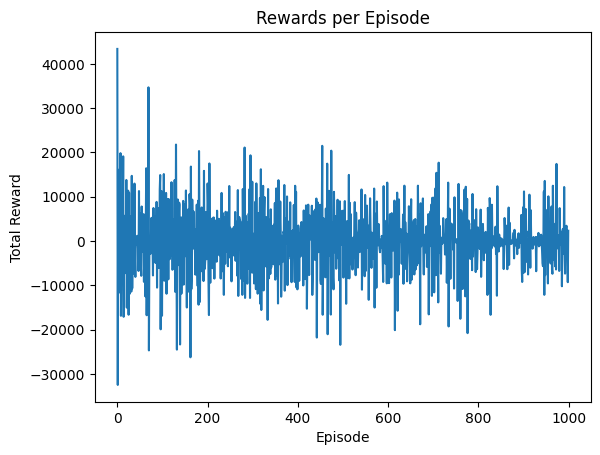

In [ ]:
EnvExp2 = SimplifiedContinuousTradingEnvironmentDQN("pepsi_data.csv", "cola_data.csv")
AgentExp2 = DQNAgent(state_size=5, action_size=4)
rewards2 = train_dqn_agent(env=EnvExp2, agent=AgentExp2, num_episodes=1000)

In [ ]:
# Example for JESSE

# Choose, for each state component, the value that you want to evaluate your model on
balances = [0, 5000, 10000]
pepsi_shares = [0, 5, 10]
cola_shares = [0, 5, 10]
pepsi_trend = [-5, 0, 5]
cola_trend = [-5, 0, 5]
states = np.array([balances, pepsi_shares, cola_shares, pepsi_trend, cola_trend])
q_tables = AgentExp2.generate_q_tables(state_values=states)
print("q_tables shape: ", q_tables.shape)
# To get the q-values returned by the model learned at ep 10 for the state  s = [5000, 0, 10, -5, 0] just fetch by:
q_val = q_tables[
    10, 1, 0, 2, 0, 1  # Ep 10  # 5000 = balances[1]  # 0 = pepsi_shares[0]  # ...
]
# q_val contain now the q_values for s and every possible action:
print(q_val)
# Acces to Q(s,a) by q_val[a]

q_tables shape:  (1000, 3, 3, 3, 3, 3, 4)
[237.62567139 226.5506134  230.64872742 241.5375061 ]


## 2.5 Experiment 2 results
---

### Performance

Plot and analyse results...

### Learned Q-values

Display leanred Q-value surface and gain insight...

# Part 3. **Complete continuous** stock trading problem
---
---

Explain...

## 3.1 Deep Q-Learning for stock trading with multiple continuous technical indicators
---

### **Complete continuous** stock trading problem with deep Q-Learning

Explain...

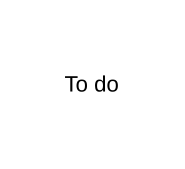

In [ ]:
display(SVG(url="https://drive.google.com/uc?id=1lVKdS06Sc9lCtW_P3Ek48gTYdJfvfRz-"))

## 3.2 Experiment 3: **Complete continuous** stock trading problem
---

In [16]:
##### Overall rmq #####
# Why adj close in this env?
# Actio will be vector
# Can we buy float share quantity (e.g. buy 1.5 pepsi shares)?


class CompleteContinuousTradingEnvironment(TradingEnvironment):
    """
    The environment corresponding to the 3rd experiment.

    TODO
    State space = [0,+inf] x []
        representing respectively
            the remaining balance,
            the number of pepsi shares held,
            the number of cola shares held,
            the trend of pepsi stock,
            the trend of cola stock

    Action space = {0..3} for
        0: Sell all
        1: Hold
        2: Buy Pepsi
        3: Buy Cola

    The state is represented with an index in {0..1584} for Q-value tables
    """

    def __init__(self, pepsi_file: str, cola_file: str, h_max: int):
        self.h_max = h_max
        # Why not vector?
        self.action_dim = (2 * h_max + 1) ** 2
        # Balance, shares per stock and MACD, MACD signal, RSI, CCI, ADX for each stock
        self.observation_dim = 1 + 2 + 6 * 2

        super().__init__(
            pepsi_file,
            cola_file,
            observation_dim=self.observation_dim,
            action_dim=self.action_dim,
        )

        self.pepsi_data = self.load_data(pepsi_file)
        self.cola_data = self.load_data(cola_file)

        self.state = self.initialize_state()

    def load_data(self, file_path: str) -> pd.DataFrame:
        """
        Load the stock data and computes the financial indicators

        Args:
            file_path: str, The file containing all the stock prices

        Returns:
            data: pd.DataFrame, The DataFrame containing the stock prices and the indicators
        """
        data = pd.read_csv(file_path)
        # Add technical indicators
        data["MACD"], data["MACDSignal"], _ = talib.MACD(data["Adj Close"])
        data["RSI"] = talib.RSI(data["Adj Close"])
        data["CCI"] = talib.CCI(data["High"], data["Low"], data["Adj Close"])
        data["ADX"] = talib.ADX(data["High"], data["Low"], data["Adj Close"])
        # Drop NaNs
        return data.dropna()

    def initialize_state(self) -> np.ndarray:
        """
        Returns the initial state of the environment
        State includes balance, shares, closing price, MACD, MACD signal, RSI, CCI and ADX for each stock
        """
        return np.array(
            [10000.0, 0, 0]
            + self.pepsi_data.iloc[0][
                ["Adj Close", "MACD", "MACDSignal", "RSI", "CCI", "ADX"]
            ].tolist()
            + self.cola_data.iloc[0][
                ["Adj Close", "MACD", "MACDSignal", "RSI", "CCI", "ADX"]
            ].tolist()
        )

    def step(self, action: Tuple[int, int]) -> Tuple[np.ndarray, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            state: np.ndarray, The next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        self._check_action_validity(action)
        self.state = self._trade(action)
        self.current_step += 1
        done = self.current_step >= len(self.pepsi_data) - 1
        reward = self._compute_reward()

        return self.state, reward, done

    def reset(self) -> np.ndarray:
        self.state = self.initialize_state()
        self.current_step = 0
        return self.state

    def _trade(self, action: Tuple[int, int]) -> np.ndarray:
        next_state = self.state

        price_pepsi = self._get_stock_price(self.current_step, self.pepsi_data)
        price_cola = self._get_stock_price(self.current_step, self.cola_data)

        next_state[0] -= price_pepsi * action[0] + price_cola * action[1]
        next_state[1] += action[0]
        next_state[2] += action[1]

        next_state[3:9] = self._get_indicator(self.current_step, self.pepsi_data)
        next_state[9:15] = self._get_indicator(self.current_step, self.cola_data)

        return next_state

    def _get_indicator(selfself, step: int, stock_data: pd.DataFrame) -> np.ndarray:
        return stock_data.iloc[step][
            ["Adj Close", "MACD", "MACDSignal", "RSI", "CCI", "ADX"]
        ].tolist()

    def _check_action_validity(self, action: Tuple[int, int]) -> None:
        """
        Ensures that parsed action is valid, raise an error if it is not
        """
        price_pepsi = self._get_stock_price(self.current_step, self.pepsi_data)
        price_cola = self._get_stock_price(self.current_step, self.cola_data)
        new_balance = self.state[0] - action[0] * price_pepsi - action[1] * price_cola
        if new_balance < 0:
            raise ValueError("Action must be in [0,{}]".format(self.action_dim - 1))

    def _compute_portfolio_value(self) -> float:
        pepsi_price = self.pepsi_data.iloc[self.current_step]["Adj Close"]
        cola_price = self.cola_data.iloc[self.current_step]["Adj Close"]
        return self.state[0] + self.state[1] * pepsi_price + self.state[2] * cola_price

In [20]:
# TODO check that action is legit in agent
class DQNAgentExp3:
    def __init__(self, state_size: int, action_size: int):
        self.state_size = state_size
        self.action_size = action_size
        self.h_max = 20
        self.memory = []  # Memory buffer for experience replay

        # Hyperparameters
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001

        self.model = self._build_model()

    def _build_model(self):
        """
        Define a simple Neural Network model

        Returns:
            model: nn.Sequential, The model built
        """
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size),
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def remember(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ) -> None:
        """
        Store the given transition into the memory for experience replay with action represented as integer

        Args:
            state: np.ndarray, The initial state of the transition
            action: int, The action taken
            reward: float, The reward returned by the environment
            next_state: np.ndarray, The final state of the transition
            done: bool, True if the episode is terminated or truncated
        """
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state: np.ndarray) -> Tuple[int, int]:
        """
        Choose the action to pick according to current model with eps-greedy

        Args:
            state: np.ndarray, The current state

        Returns:
            action: int, The action to pick
        """
        balance = state[0]
        shares_pepsi = state[1]
        price_pepsi = state[3]
        shares_cola = state[2]
        price_cola = state[9]

        if np.random.rand() <= self.epsilon:
            # Random action
            action_pepsi = random.randrange(
                -int(shares_pepsi),
                int(
                    min(
                        int((balance + shares_cola * price_cola) / price_pepsi),
                        self.h_max,
                    )
                ),
            )
            action_cola = random.randrange(
                -int(shares_cola),
                int(
                    min(
                        int((balance - action_pepsi * price_pepsi) / price_cola),
                        self.h_max,
                    )
                ),
            )
            return (action_pepsi, action_cola)

        state = torch.from_numpy(state).float().unsqueeze(0)
        act_values = self.model(state)
        best_act = np.argsort(act_values.cpu.data.numpy())
        for act in best_act[::-1]:
            act_as_tuple = self.decode_action(act)
            valid = self._check_action_validity(act_as_tuple, state)
            if valid:
                return act_as_tuple

    def replay(self, batch_size: int) -> None:
        """
        Update the model parameters by experiencing through the replay buffer

        Args:
            batch_size: int, The size of the batch to experience on
        """
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                target = reward + self.gamma * np.amax(
                    self.model(next_state).detach().cpu().numpy()
                )
            state = torch.from_numpy(state).float().unsqueeze(0)
            target_f = self.model(state)
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = nn.functional.mse_loss(target_f, self.model(state))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def decode_action(self, action: int) -> Tuple[int, int]:
        pepsi_action = action // (2 * self.h_max + 1) - self.h_max
        cola_action = action % (2 * self.h_max + 1) - self.h_max
        return pepsi_action, cola_action

    def encode_action(self, action: Tuple[int, int]) -> int:
        action = (
            (2 * self.h_max + 1) * (action[0] + self.h_max) + action[1] + self.h_max
        )
        return action

    def _check_action_validity(
        self, action: Tuple[int, int], state: np.ndarray
    ) -> bool:
        """
        Ensures that parsed action is valid, return a bool
        """
        balance = state[0]
        shares_pepsi = state[1]
        price_pepsi = state[3]
        shares_cola = state[2]
        price_cola = state[9]
        if action[0] < -shares_pepsi or action[1] < shares_cola:
            return False
        new_balance = balance - action[0] * price_pepsi - action[1] * price_cola
        if new_balance < 0:
            return False
        return True

In [21]:
def train_agent_exp_3(
    env: CompleteContinuousTradingEnvironment,
    agent: DQNAgentExp3,
    num_episodes: int,
    batch_size: int,
):
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

        agent.replay(batch_size)  # Experience replay
        rewards_per_episode.append(total_reward)

        print(
            f"Episode: {episode+1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}"
        )

    # Plotting the rewards
    plt.plot(rewards_per_episode)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.show()

    return rewards_per_episode

In [22]:
# Initialize the environment and the agent
h_max = 20  # Max number of shares to buy/sell
env = CompleteContinuousTradingEnvironment("pepsi_data.csv", "cola_data.csv", h_max)
state_size = env.observation_dim
action_size = env.action_dim
agent = DQNAgentExp3(state_size, action_size)

# Train the agent
num_episodes = 1000
batch_size = 32
rewards = train_agent_exp_3(env, agent, num_episodes, batch_size)

## 3.3 Experiment 3 results
---

### Performance

Plot and analyse results...

### Learned Q-values

Display leanred Q-value surface and gain insight...

# Conclusions
---
---

Explain...